# The wisdom of crowds for movie ratings

This notebooks replicates and extends the results presented in Mattei & Garreau (2024) on using crowds to predict the ratings of future movies, based on data collected by Simoiu et al. (2019). Predictions will be assessed using the squared error as well as non-convex losses discussed by Barron (2019). 

References:

- J. T. Barron. A general and adaptive robust loss function. Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 4331–4339, 2019

- P.-A. Mattei and D. Garreau, Are ensembles getting better all the time?, arXiv:2311.17885, 2024

- C. Simoiu, C. Sumanth, A. Mysore, and S. Goel, Studying the “wisdom of crowds” at scale, Proceedings of the AAAI Conference on Human Computation and Crowdsourcing, vol. 7, pp. 171–179, 2019.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

In [2]:
sns.set_context("notebook", rc={"lines.linewidth": 2}, font_scale = 1.2)
sns.set_palette("colorblind")

# 1. Loading the data

We begin by loading the data from Simoiu et al. (2019). The movie "Patient Zero" has no rating, probably because it came out later than anticipated so we fill it with a score extracted from Rotten Tomatoes.

In [3]:
true_ratings = pd.read_csv("data/true_ratings.txt", low_memory=False, sep=' ')
true_ratings['patient_zero'] = 26
movie_names = true_ratings.columns

In [4]:
crowd_ratings = {i:np.loadtxt("data/"+i+".txt",usecols=1,skiprows=1) for i in movie_names}

We can take a look at the ground-truth ratings $y$, and compare them with the prediction of the ‘‘infinite" ensemble $\bar{y}_\infty$, which is just the average of all ratings for a given movie.

In [5]:
ytrue = np.squeeze(true_ratings)
yinf = np.squeeze(pd.DataFrame(np.array([np.mean(ratings) for name,ratings in crowd_ratings.items()]),index = movie_names))
df = pd.concat([ytrue,yinf],axis = 1)
df.columns = ["true","predicted"]
df

,true,predicted
the_great_wall,49,58.057143
fifty_shades_darker,53,46.301991
american_violence,40,60.566964
boss_baby,62,64.879386
the_shack,84,57.650442
john_wick,89,60.154525
kong_skull_island,74,58.932886
ghost_in_the_shell,62,56.590604
lego_batman_movie,82,64.145374
rings,28,55.913333


# 2. Replicating the results

As detailed in the experimantal section of Mattein & Garreau (2024), for each movie and for each $K \in \{1,\ldots, 50\}$, we sample randomly (with replacement) $K$ of its ratings to build an ensemble prediction $\bar{y}_K\in [1,100]$. We repeat this experiment $10,000$ times to be able to approximate the quantity that interests us, $\mathbb{E}[L(\bar{y}_K)]$, where $L$ is a loss function.

For instance, $L$ can simply be the squared loss
$$L_\text{MSE}(\bar{y}_K) = (\bar{y}_K - y)^2,$$
that is a convex in $\bar{y}_K$. We will also look at two non-convex losses: the Welsh loss
$$L_\text{W}(\bar{y}_K) = 1- e^{-(\bar{y}_K - y)^2/(2c)^2},$$
and the Geman-Mclure loss,
$$L_\text{GM}(\bar{y}_K) = \frac{2((\bar{y}_K - y)/c)^2}{((\bar{y}_K - y)/c)^2 +4},$$
that both depend on a hyper-parameter $c>0$. These losses are convex when $\bar{y}_K \in (y-c,y+c)$ and concave elsewhere. For the movie experiment, we will choose $c = 10$. For more details on these losses, see Barron (2019) and Mattei & Garreau (2024).

In [6]:
def welsch (x, c = 10): 
    return 1 - np.exp(-(x/c)**2/2)

def gmloss (x, c = 10): 
    return 2*(x/c)**2/( (x/c)**2 + 4)

In [7]:
# Here we compute all predictions

K = 50
nrep = 10000
all_preds = np.zeros(shape = (nrep,K,movie_names.shape[0]))

for i in range(movie_names.shape[0]):
    preds = [ np.random.choice(crowd_ratings[movie_names[i]], size = K, replace=True) for j in range(nrep)]
    all_preds[:,:,i] = np.cumsum(preds,1)/np.arange(1,K+1)

In [8]:
# Here we compute all losses and arrange them into pandas dataframes

err = all_preds -  np.expand_dims(ytrue,(0,1))
curves_squaredloss = np.zeros((nrep,K,movie_names.shape[0]+1))
curves_w = np.zeros((nrep,K,movie_names.shape[0]+1))
curves_gm = np.zeros((nrep,K,movie_names.shape[0]+1))

for rep in range(nrep):
    curves_squaredloss[rep,:,0] = np.arange(1,K+1)
    curves_w[rep,:,0] = np.arange(1,K+1)
    curves_gm[rep,:,0] = np.arange(1,K+1)
    
curves_squaredloss[:,:,1:] = err**2
curves_w[:,:,1:] = welsch(err)
curves_gm[:,:,1:] = gmloss(err)

curves_names = ["K"] + list(movie_names)
df_squaredloss = pd.DataFrame(curves_squaredloss.reshape((K*nrep,-1)), columns = curves_names)
df_squaredloss = pd.melt(df_squaredloss,id_vars='K')

df_w = pd.DataFrame(curves_w.reshape((K*nrep,-1)), columns = curves_names)
df_w = pd.melt(df_w,id_vars='K')

df_gm = pd.DataFrame(curves_gm.reshape((K*nrep,-1)), columns = curves_names)
df_gm = pd.melt(df_gm,id_vars='K')

Let's first look at the squared loss. Since it is convex, our theory predicts that it should get better as $K$ grows, and that's indeed the case:

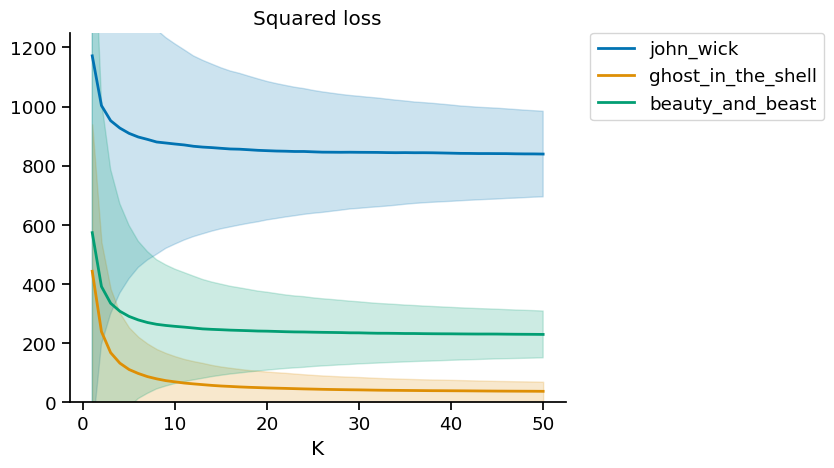

In [9]:
ax = sns.lineplot(data=df_squaredloss[df_squaredloss["variable"].isin(["john_wick","beauty_and_beast", "ghost_in_the_shell"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
ax
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1250))
plt.title("Squared loss")
plt.xlabel("K")
plt.show()

Let us now look at the two nonconvex losses. Out theory predicts that movies that, 
for movies such that $|y - \bar{y}_\infty| < 10$, ensembles will be eventually getting better for large $K$. Conversely, when  $|y - \bar{y}_\infty| > 10$ ensembles should eventually worsen. We can take a look at these $|y - \bar{y}_\infty| > 10$.

In [10]:
np.abs(yinf - ytrue)

the_great_wall           9.057143
fifty_shades_darker      6.698009
american_violence       20.566964
boss_baby                2.879386
the_shack               26.349558
john_wick               28.845475
kong_skull_island       15.067114
ghost_in_the_shell       5.409396
lego_batman_movie       17.854626
rings                   27.913333
fist_fight              12.276261
beauty_and_beast        14.921610
the_space_between_us     0.364017
logan                   31.731092
life                     8.536842
fast_and_furious_8      20.978947
smurfs_lost_village     13.801053
patient_zero            34.653277
the_circle              38.290526
leap                    12.788136
dtype: float64

The previous results suggest that, for John Wick 2, ensembles should be getting worse (since $|y - \bar{y}_\infty| \approx 28.85$), they should also get worse for Beauty and the Beast (since $|y - \bar{y}_\infty| \approx 14.92$), but they should be getting better for Ghost in the Shell (since $|y - \bar{y}_\infty| \approx 5.41$). We can check that this is indeed true.

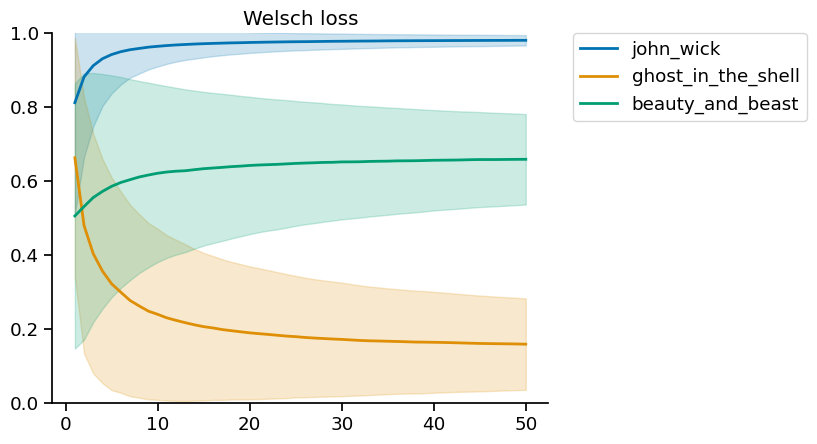

In [11]:
ax = sns.lineplot(data=df_w[df_w["variable"].isin(["john_wick","beauty_and_beast", "ghost_in_the_shell"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
ax
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1))
plt.title("Welsch loss")
plt.show()

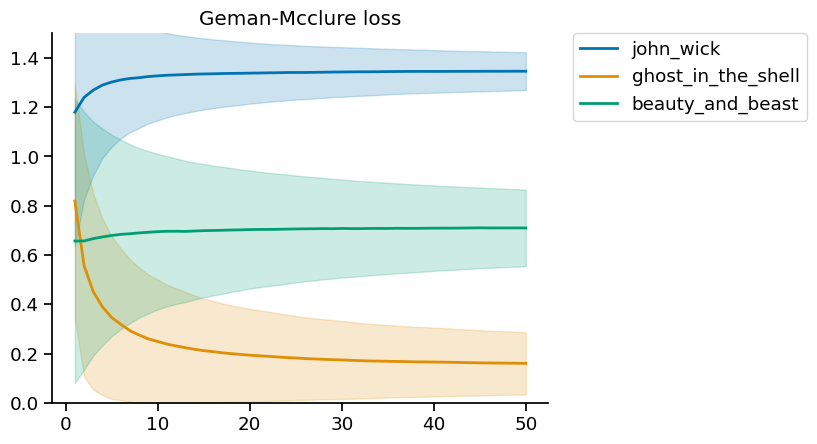

In [12]:
ax = sns.lineplot(data=df_gm[df_w["variable"].isin(["john_wick","beauty_and_beast", "ghost_in_the_shell"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
ax
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim((0,1.5))
plt.title("Geman-Mcclure loss")
plt.show()

# Three more movies

The three movies we just saw are studied in the experimental section of Mattei & Garreau (2024). Three more movies are studied in the appendix: Logan, The Space Between Us, and Smurfs, The Lost Village. As illustrated in the following figures, the results are again in line with our theory. An interesting feature of the Smurfs movie is that  while it is in the nonconvex part of the loss, it is close to the inflexion point, since $|y - \bar{y}_\infty| \approx 13.8$ is closer to $10$ than any of the five other movies. This perhaps explains while the Welsch and Geman-McClure losses are initially decreasing, and eventually increasing.

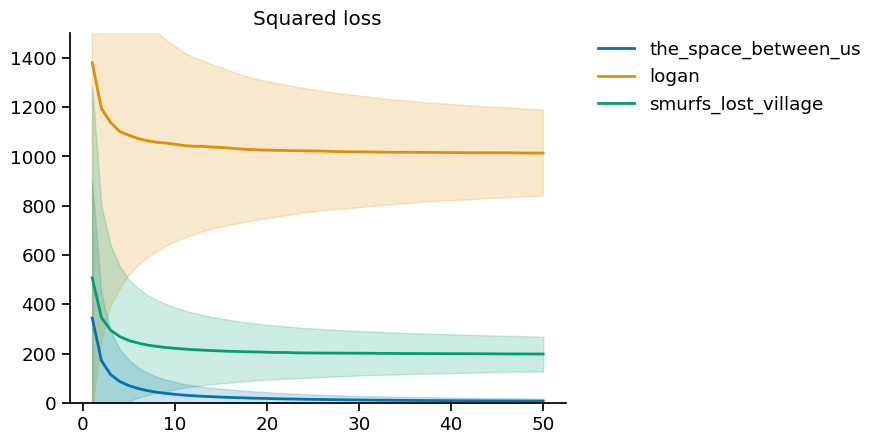

In [21]:
ax = sns.lineplot(data=df_squaredloss[df_squaredloss["variable"].isin(["the_space_between_us","logan", "smurfs_lost_village"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
ax
plt.ylim((0,1500))
plt.title("Squared loss")
plt.show()

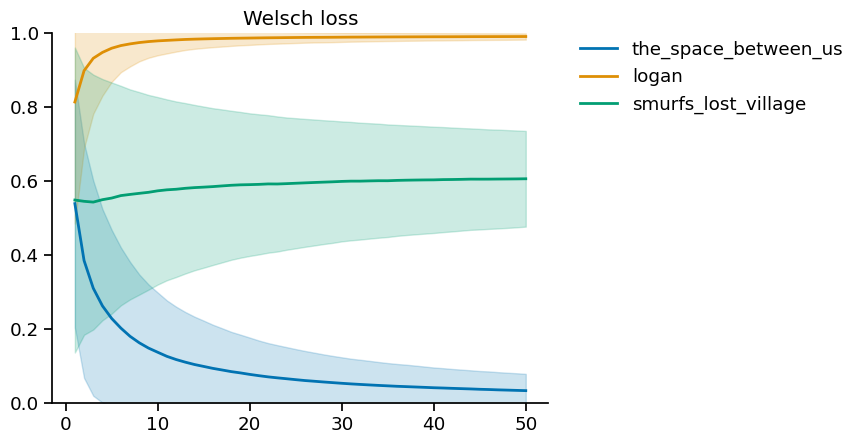

In [22]:
ax = sns.lineplot(data=df_w[df_w["variable"].isin(["the_space_between_us","logan", "smurfs_lost_village"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
ax
plt.ylim((0,1))
plt.title("Welsch loss")
plt.show()

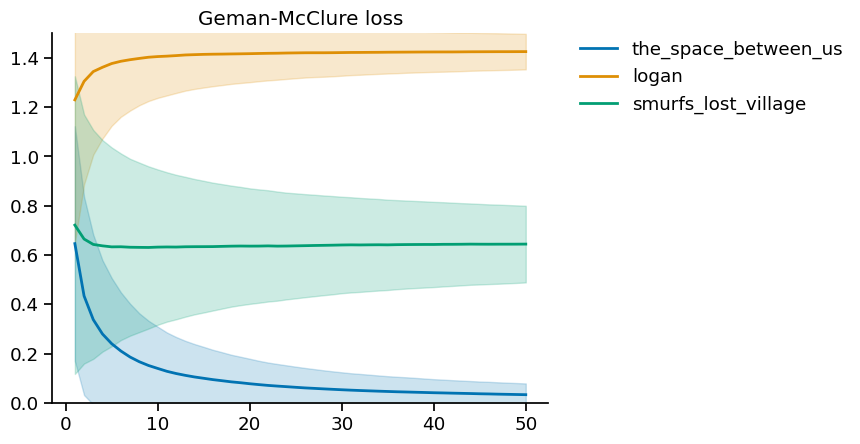

In [23]:
ax = sns.lineplot(data=df_gm[df_gm["variable"].isin(["the_space_between_us","logan", "smurfs_lost_village"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
ax
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
plt.ylim((0,1.5))
plt.title("Geman-McClure loss")
plt.show()

To see a bit more closely what's happening to the Smurfs, we may zoom in.

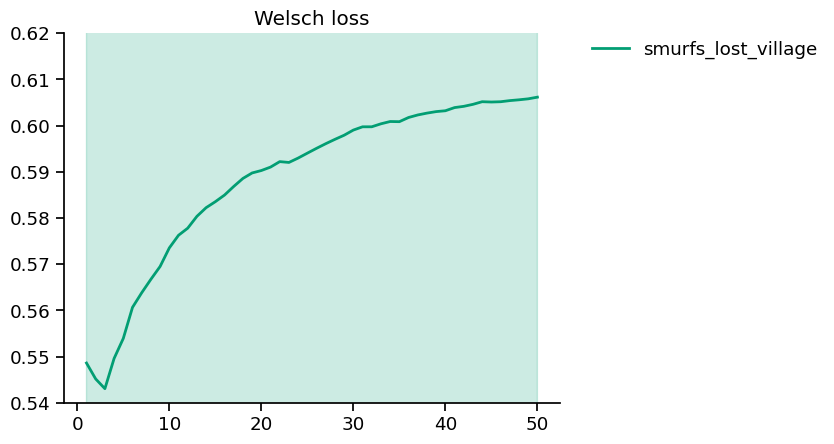

In [26]:
ax = sns.lineplot(data=df_w[df_w["variable"].isin(["smurfs_lost_village"])], x="K", hue = 'variable', y='value', ci= 'sd',palette= [sns.color_palette("colorblind")[2]])
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
ax
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
plt.ylim((0.54,0.62))
plt.title("Welsch loss")
plt.show()

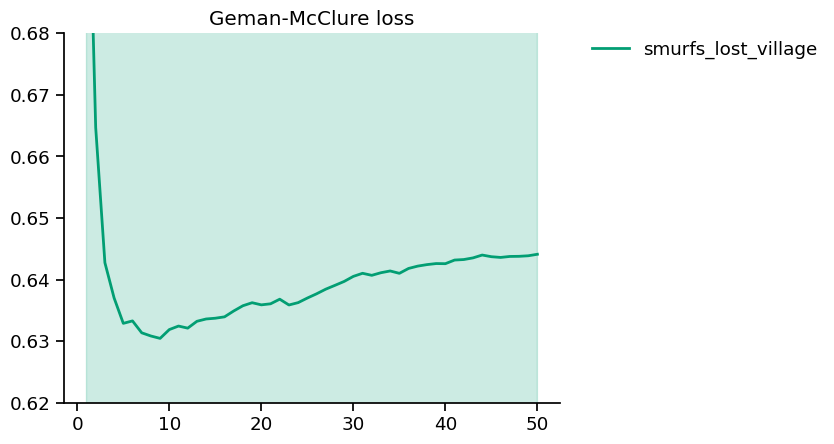

In [24]:
ax = sns.lineplot(data=df_gm[df_gm["variable"].isin(["smurfs_lost_village"])], x="K", hue = 'variable', y='value', ci= 'sd',palette= [sns.color_palette("colorblind")[2]])
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
ax
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
plt.ylim((0.62,0.68))
plt.title("Geman-McClure loss")
plt.show()

# The other movies

Finally, we indicate how to plot any other movie. For instance, here's Fast and Furious 8, for which $|y - \bar{y}_\infty| \approx  20.98$, so we expect the squared loss to go down, and the other non-convex losses to go up.

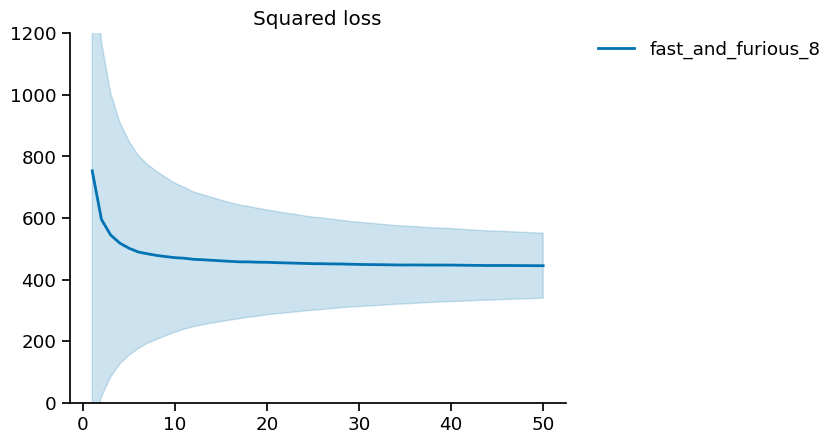

In [39]:
ax = sns.lineplot(data=df_squaredloss[df_squaredloss["variable"].isin(["fast_and_furious_8"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
ax
plt.ylim((0,1200))
plt.title("Squared loss")
plt.show()

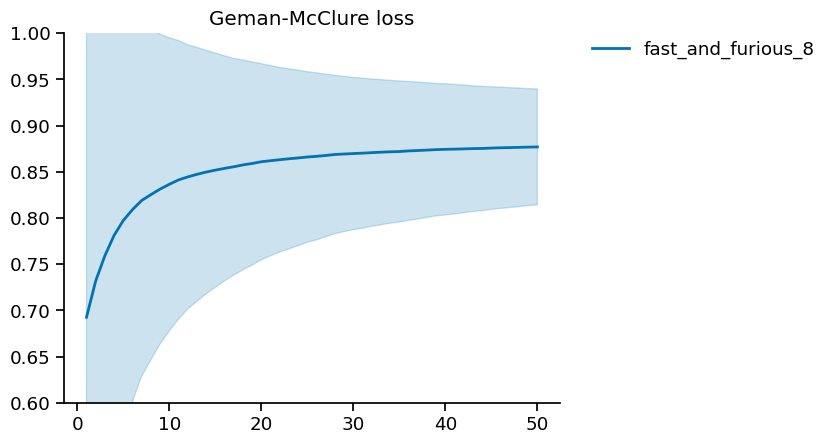

In [40]:
ax = sns.lineplot(data=df_w[df_w["variable"].isin(["fast_and_furious_8"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
ax
plt.ylim((0.6,1.))
plt.title("Geman-McClure loss")
plt.show()

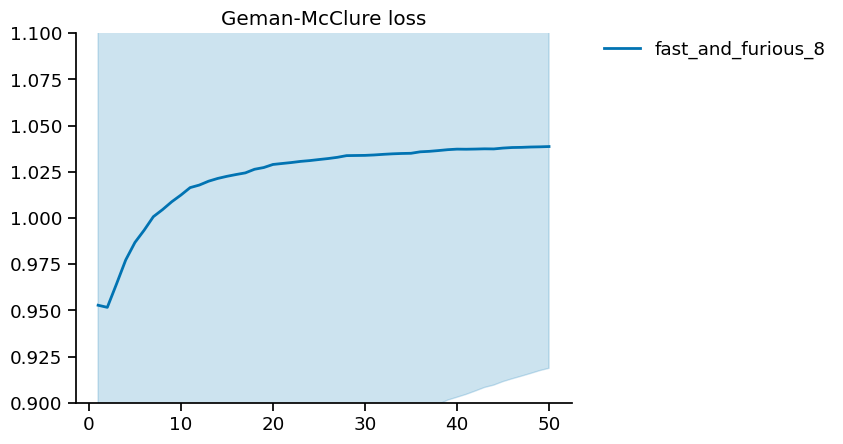

In [41]:
ax = sns.lineplot(data=df_gm[df_gm["variable"].isin(["fast_and_furious_8"])], x="K", hue = 'variable', y='value', ci= 'sd')
ax.set(xlabel=None)
ax.set(ylabel=None)
sns.despine()
leg = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg.get_frame().set_linewidth(0.0)
ax
plt.ylim((0.9,1.1))
plt.title("Geman-McClure loss")
plt.show()